# Robinhood Data Science Chanllenge Q4
- In order to improve user retention and lower churn, the growth team at Robinhood is interested in understanding why and which users withdraw money from their Robinhood account. A user is considered churned when their equity value (amount of money in Robinhood account) falls below 10 for a period of 28 consecutive calendar days or longer.

## Datasets:
### features_data.csv:
- user_id - unique id for every user
- risk_tolerance - self-reported risk tolerance of the user
- investment_experience - self reported investment experience of the user
- liquidity_needs - self reported liquidity needs of the user
- time_horizon - self reported investment time horizon of the user
- platform - which platform (iOS or Android) the user is on
- time_spent - amount of time spent on the app
- first_deposit_amount - value of the amount first deposited
- instrument_type_first_traded - type of instrument first traded

### equity_value_data.csv:
- contains user_id and equity_value for user along with timestamps for days when the user’s equity value is greater than or equal to 10.

### a). What percentage of users have churned in the data provided? [4 points]
### b). Build a classifier that given a user with their features assigns a churn probability for everyuser and predicts which users will churn. How well does your classifier perform? State any metrics you deem important here. Based on the classifier output classify each user in the dataset as churned or not churned. [5 points]
### c). List the most important features that correlate to user churn. [3 points]

In [1]:
# get all the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## 1. Import the equity_value_data and try to define the churn.

In [2]:
df_equity = pd.read_csv('equity_value_data.csv')

In [3]:
df_equity.head(10)

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
5,2016-11-23T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
6,2016-11-25T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
7,2016-11-28T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
8,2016-11-29T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
9,2016-11-30T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03


In [4]:
df_equity['timestamp'] = pd.to_datetime(df_equity['timestamp'])

### How to define the churn?
- Usually, a user is considered to churn if they do not have activities (balance below 10 in Robinhood account) in the last X days. Here we can get the last date for balance above 10 for each user using 'groupby(['user_id']).max()' and see if it is earlier than (timestamp.max() - 28) days.
- Howerver, in this problem, inferred from the description, a user might churn at any time and then come back. For e.g, today is 1/25/2019, a user could have less than 10 dollars in the account for the entire June 2018, and thus is consider to churn. But then he made a deposit on 07/01/2018, and had a balance above 10 for the following days.

#### Therefore we calculate the difference for each pair of adjacent dates for every user. If there exists one difference >= 28 days, the user is labeled as 'churn'.
- I will brifely describe my way of achieving this goal. I make two copies of 'equity_value_data', df1 and df2. For df2, I remove the first date for each user and concatenate the overall last date for each user. Then df2 - df1 will give us all the differences.

In [5]:
from dateutil import parser
df_lastDay = pd.DataFrame({'user_id':df_equity['user_id'].unique()})
df_lastDay['timestamp'] = parser.parse('2017-08-18')

In [6]:
df2 = pd.concat([df_equity, df_lastDay])

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [7]:
df_minDate = df_equity[['user_id', 'timestamp']].groupby(['user_id']).min().reset_index()

In [8]:
df2 = df2.merge(df_minDate, on=['user_id'])

In [9]:
df2 = df2[df2['timestamp_x']!=df2['timestamp_y']]

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119158 entries, 1 to 1124741
Data columns (total 4 columns):
close_equity    1113574 non-null float64
timestamp_x     1119158 non-null datetime64[ns]
user_id         1119158 non-null object
timestamp_y     1119158 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 42.7+ MB


In [11]:
df2.head()

,close_equity,timestamp_x,user_id,timestamp_y
1,48.16,2016-11-17,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
2,48.16,2016-11-18,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
3,48.16,2016-11-21,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
4,48.16,2016-11-22,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16
5,48.16,2016-11-23,bcef4fa9b0bdf22bcf7deae708decf03,2016-11-16


In [12]:
df2 = df2.sort_values(by=['user_id', 'timestamp_x'])

In [13]:
df2.head()

,close_equity,timestamp_x,user_id,timestamp_y
508192,1173.5640,2016-08-19,0012db34aa7b083f5714e7831195e54d,2016-08-18
508193,1253.0597,2016-08-22,0012db34aa7b083f5714e7831195e54d,2016-08-18
508194,1252.9050,2016-08-23,0012db34aa7b083f5714e7831195e54d,2016-08-18
508195,1262.1360,2016-08-24,0012db34aa7b083f5714e7831195e54d,2016-08-18
508196,1226.4250,2016-08-25,0012db34aa7b083f5714e7831195e54d,2016-08-18


In [14]:
df1 = df_equity.copy()

In [15]:
df1 = df1.sort_values(by=['user_id', 'timestamp'])

In [16]:
df1.head()

,timestamp,close_equity,user_id
505994,2016-08-18,1211.6055,0012db34aa7b083f5714e7831195e54d
505995,2016-08-19,1173.5640,0012db34aa7b083f5714e7831195e54d
505996,2016-08-22,1253.0597,0012db34aa7b083f5714e7831195e54d
505997,2016-08-23,1252.9050,0012db34aa7b083f5714e7831195e54d
505998,2016-08-24,1262.1360,0012db34aa7b083f5714e7831195e54d


In [17]:
days = []
for i in range(len(df1)):
    num_days = (df2.iloc[i]['timestamp_x'] - df1.iloc[i]['timestamp']).days
    days.append(num_days)
    if i % 100000 == 0:
        print(i)
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


In [18]:
df2['days'] = pd.Series(days)

In [19]:
df_churn = df2.groupby(['user_id']).max().reset_index()

In [20]:
df_churn['churn'] = (df_churn['days'] >= 28).astype(int)
df_churn.head(10)

,user_id,close_equity,timestamp_x,timestamp_y,days,churn
0,0012db34aa7b083f5714e7831195e54d,1262.1360,2017-08-18,2016-08-18,4.0,0
1,001d6c77dbdb3213cead7673f250bfdc,4030.4577,2017-08-18,2016-08-18,4.0,0
2,002e4653171ddc61c3cd30603cd7bd3e,134.3800,2017-08-18,2017-02-16,4.0,0
3,00384fa9be6fdca1b786bae70d78f88f,518.0000,2017-08-18,2017-02-23,4.0,0
4,0042aac295a0d4df88f4b83012778bd4,2559.1550,2017-08-18,2016-08-18,4.0,0
5,00440034cc4152bfb01b30f5c381c4e3,86.8000,2017-08-18,2016-12-30,4.0,0
6,004aab1640f3a04b87b1f404fb4c018d,25.4400,2017-08-18,2017-01-13,4.0,0
7,004ea9d7662aa8dc840bbff212cfa4b8,100.9800,2017-08-18,2017-02-28,4.0,0
8,005d630a68b4ab3a2f4cd49d9a87c50d,180.2600,2017-08-18,2016-08-18,50.0,1
9,00a9602e72eb34cb17aaad6ce62730b6,143.7800,2017-08-18,2016-08-17,157.0,1


In [21]:
df_churn['churn'].mean()

0.16869627507163323

### a). About 17% users have churned.

## 2. Import the features_data and do some preprocessing

In [22]:
df_feature = pd.read_csv('features_data.csv')

In [23]:
df_feature.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91


In [24]:
df = df_feature.merge(df_churn[['user_id', 'churn']], on='user_id')

In [25]:
df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5584 entries, 0 to 5583
Data columns (total 10 columns):
risk_tolerance                  5584 non-null object
investment_experience           5584 non-null object
liquidity_needs                 5584 non-null object
platform                        5584 non-null object
time_spent                      5584 non-null float64
instrument_type_first_traded    5584 non-null object
first_deposit_amount            5584 non-null float64
time_horizon                    5584 non-null object
user_id                         5584 non-null object
churn                           5584 non-null int32
dtypes: float64(2), int32(1), object(7)
memory usage: 458.1+ KB


In [27]:
df.describe()

,time_spent,first_deposit_amount,churn
count,5584.000000,5584.000000,5584.000000
mean,34.509706,633.566805,0.168696
std,155.080551,2118.323263,0.374517
min,0.000000,0.000000,0.000000
25%,2.848908,50.000000,0.000000
50%,13.474708,100.000000,0.000000
75%,33.823829,500.000000,0.000000
max,8788.329450,50000.000000,1.000000


In [118]:
df = df[df['time_spent'] < 4000]

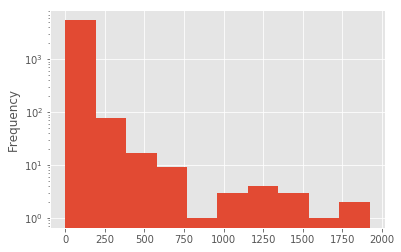

In [119]:
df['time_spent'].plot.hist(log=True)

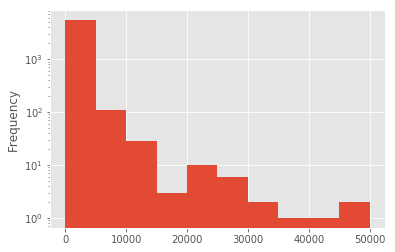

In [58]:
df['first_deposit_amount'].plot.hist(log=True)

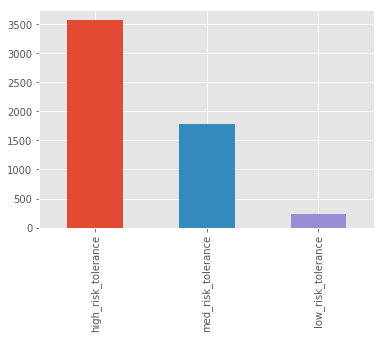

In [32]:
df['risk_tolerance'].value_counts().plot.bar()

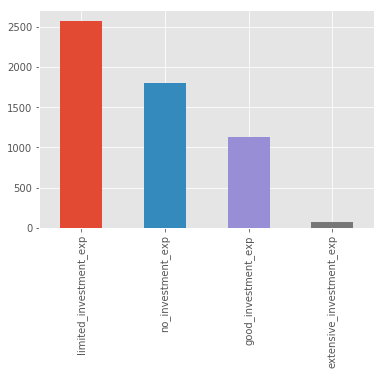

In [33]:
df['investment_experience'].value_counts().plot.bar()

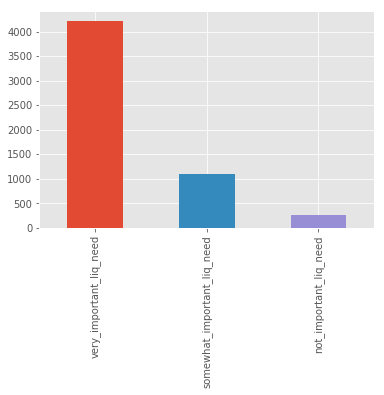

In [34]:
df['liquidity_needs'].value_counts().plot.bar()

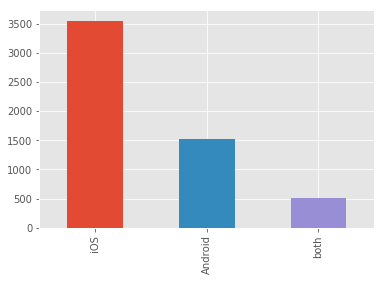

In [35]:
df['platform'].value_counts().plot.bar()

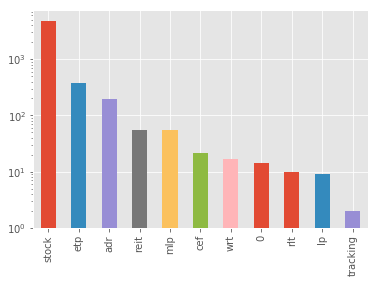

In [36]:
df['instrument_type_first_traded'].value_counts().plot.bar(log=True)

There are many categories for this and we will see if this feature is not important, we can combine levels < 100 into 'instrument_others'.

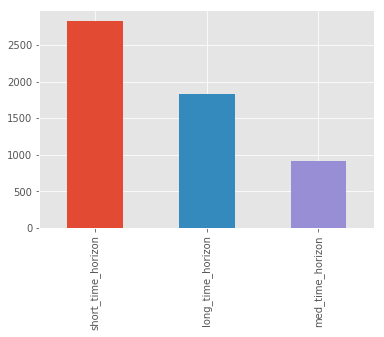

In [37]:
df['time_horizon'].value_counts().plot.bar()

In [28]:
cate_vars = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'instrument_type_first_traded', 'time_horizon']

In [29]:
df_dummies = pd.get_dummies(df[cate_vars], columns=cate_vars)

In [30]:
df = df.join(df_dummies)

In [31]:
df.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn,...,instrument_type_first_traded_lp,instrument_type_first_traded_mlp,instrument_type_first_traded_reit,instrument_type_first_traded_rlt,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0,...,0,0,0,0,1,0,0,0,1,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0,...,0,0,0,0,1,0,0,0,0,1
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0,...,0,0,0,0,1,0,0,1,0,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0,...,0,0,0,0,1,0,0,0,0,1
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,1,...,0,0,0,0,1,0,0,1,0,0


#### We can look at the correlation matrix to determin which features are important

In [32]:
corr_matrix = df.corr()

In [33]:
corr_matrix['churn'].sort_values()

time_horizon_med_time_horizon                    -0.033370
instrument_type_first_traded_reit                -0.030402
liquidity_needs_somewhat_important_liq_need      -0.027671
liquidity_needs_not_important_liq_need           -0.026251
platform_Android                                 -0.019236
time_spent                                       -0.017578
risk_tolerance_med_risk_tolerance                -0.015509
instrument_type_first_traded_stock               -0.012987
instrument_type_first_traded_0                   -0.011838
instrument_type_first_traded_cef                 -0.010998
risk_tolerance_low_risk_tolerance                -0.010203
investment_experience_limited_investment_exp     -0.007577
instrument_type_first_traded_lp                  -0.004420
time_horizon_short_time_horizon                  -0.003746
investment_experience_no_investment_exp          -0.003049
instrument_type_first_traded_mlp                 -0.001348
investment_experience_extensive_investment_exp    0.0007

In [34]:
y = df['churn'].values

In [35]:
selected_features = list(df.columns)
for f in cate_vars:
    selected_features.remove(f)
selected_features.remove('user_id')
selected_features.remove('churn')
selected_features

['time_spent',
 'first_deposit_amount',
 'risk_tolerance_high_risk_tolerance',
 'risk_tolerance_low_risk_tolerance',
 'risk_tolerance_med_risk_tolerance',
 'investment_experience_extensive_investment_exp',
 'investment_experience_good_investment_exp',
 'investment_experience_limited_investment_exp',
 'investment_experience_no_investment_exp',
 'liquidity_needs_not_important_liq_need',
 'liquidity_needs_somewhat_important_liq_need',
 'liquidity_needs_very_important_liq_need',
 'platform_Android',
 'platform_both',
 'platform_iOS',
 'instrument_type_first_traded_0',
 'instrument_type_first_traded_adr',
 'instrument_type_first_traded_cef',
 'instrument_type_first_traded_etp',
 'instrument_type_first_traded_lp',
 'instrument_type_first_traded_mlp',
 'instrument_type_first_traded_reit',
 'instrument_type_first_traded_rlt',
 'instrument_type_first_traded_stock',
 'instrument_type_first_traded_tracking',
 'instrument_type_first_traded_wrt',
 'time_horizon_long_time_horizon',
 'time_horizon_me

In [36]:
X = df[selected_features].values

In [37]:
X.shape, y.shape

((5584, 29), (5584,))

## 3. Model training using random forest
- I choose random forest since it deals with categorical features well and we can get directly the feature importance.

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [80]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': 200,
              'max_features': 'auto',
              'max_depth': 20,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
             }

clf = RandomForestClassifier(**parameters)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [81]:
clf.score(X_train, y_train)

0.833669129169465

In [82]:
clf.score(X_test, y_test)

0.8218442256042973

#### The accuracy score (for threshold 0.5) looks good. But the dataset is imbalanced, therefore we need to look at other metrics to evaluate the model.

In [83]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# A method to print the metric scores
def get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5):
    metric_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'f1_score']
    metric_values_train = [roc_auc_score(y_train, p_train_pred),
                           accuracy_score(y_train, p_train_pred>threshold),
                           precision_score(y_train, p_train_pred>threshold),
                           recall_score(y_train, p_train_pred>threshold),
                           f1_score(y_train, p_train_pred>threshold)
                           ]
    metric_values_test = [roc_auc_score(y_test, p_test_pred),
                         accuracy_score(y_test, p_test_pred>threshold),
                         precision_score(y_test, p_test_pred>threshold),
                         recall_score(y_test, p_test_pred>threshold),
                         f1_score(y_test, p_test_pred>threshold)
                         ]
    
    all_metrics = pd.DataFrame({'metrics':metric_names,
                               'train': metric_values_train,
                               'test': metric_values_test}).set_index('metrics')
    print(all_metrics)

In [84]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green', lw=lw, 
            label = 'ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=lw,
            label = 'ROC Test (AUC = %0.4f)' % roc_auc_test, linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('The AOC curve')
    plt.legend(loc='lower right')
    plt.savefig('roc.png')
    plt.show()
   

In [85]:
def train_print_plot(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]
    
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]
    
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


              train      test
metrics                      
AUC        0.731336  0.546534
Accuracy   0.833669  0.821844
Precision  0.000000  0.000000
Recall     0.000000  0.000000
f1_score   0.000000  0.000000


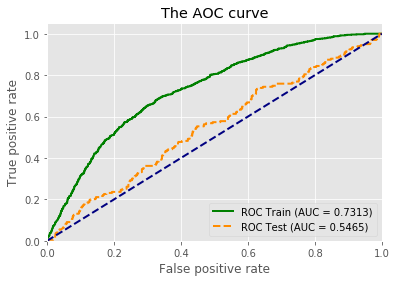

In [86]:
train_print_plot(clf, X_train, y_train, X_test, y_test)

#### There is some problem calculating some metrics. But we can infer from the AUC score that the performance is OK but there is much overfitting. Therefore I will use some oversampling method, SMOTE to get a balanced sample and train and evaluate the model again.

In [64]:
def plot_imp_tree(clf, selected_features):
    
    importances = clf.feature_importances_
    df_imp = pd.DataFrame({'feature': selected_features,
                           'importance': importances
                          }).sort_values(by=['importance'], ascending=True).set_index('feature')
    df_imp.plot.barh()
    plt.title('Importances of the variables')
    plt.tight_layout()
    #plt.figure(figsize=(80,80))
    print(df_imp)
    plt.show()

                                                importance
feature                                                   
instrument_type_first_traded_rlt                  0.000000
instrument_type_first_traded_0                    0.000000
instrument_type_first_traded_lp                   0.000000
instrument_type_first_traded_wrt                  0.000000
instrument_type_first_traded_tracking             0.000000
instrument_type_first_traded_cef                  0.000000
instrument_type_first_traded_mlp                  0.000987
investment_experience_extensive_investment_exp    0.001477
instrument_type_first_traded_reit                 0.001793
liquidity_needs_not_important_liq_need            0.007586
risk_tolerance_low_risk_tolerance                 0.007725
instrument_type_first_traded_adr                  0.009320
instrument_type_first_traded_etp                  0.010926
instrument_type_first_traded_stock                0.020146
platform_both                                     0.0204

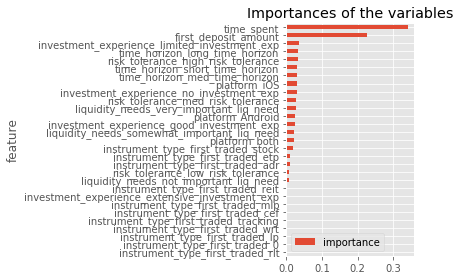

In [65]:
plot_imp_tree(clf, selected_features)

In [68]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

In [69]:
X_res, y_res = sm.fit_resample(X, y)

In [71]:
from collections import Counter
Counter(y_res)

Counter({0: 4642, 1: 4642})

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

In [73]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': 200,
              'max_features': 'auto',
              'max_depth': 20,
              'min_samples_leaf': 20,
              'random_state': 0,
              'n_jobs': -1
             }

clf = RandomForestClassifier(**parameters)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

              train      test
metrics                      
AUC        0.925704  0.899969
Accuracy   0.873300  0.855681
Precision  0.994991  0.992604
Recall     0.750000  0.718415
f1_score   0.855298  0.833540


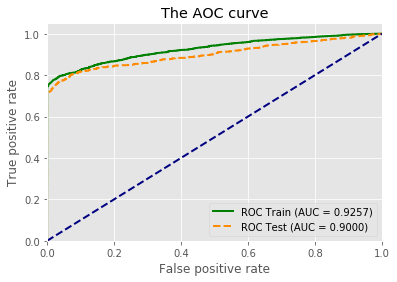

In [74]:
train_print_plot(clf, X_train, y_train, X_test, y_test)

#### Now it looks much better, but at the sacrifice of a relatively low recall score. We could change the threshold according out needs in order to get a good model.

### b). The model is evaluated and improved as discussed above. The important metrics could be infered from the correlation matrix. To do the prediction: y_pred = clf.predict(X).
### c). We can see from the feature importance from the random forrest classifier.

## 4. Summary
- First we difine the churn label.
- Then we use random forest classifier to train and predict the churn lables. Since the dataset is imbalanced, I use SMOTE to do the oversampling and improve the model.
- Some other thoughts: 
    * We could use average close_equtity from the equity_value_data as a feature.
    * Group the unimportant instrument types to reduce the dimension.
    * Change the threshold to get a disired model.